# Unsupervised cross-domain image generation

- Given two related domains, S and T, it can build a generative function G that maps an input sample from S to the domain T

- Produce face emoji that are visually appealing and capture much more of the facial characteristics than the emoji created by well-trained human annotators who use the conventional tools.

## Resource

- paper: https://arxiv.org/abs/1611.02200
- code: https://github.com/yunjey/domain-transfer-network

## Architecture

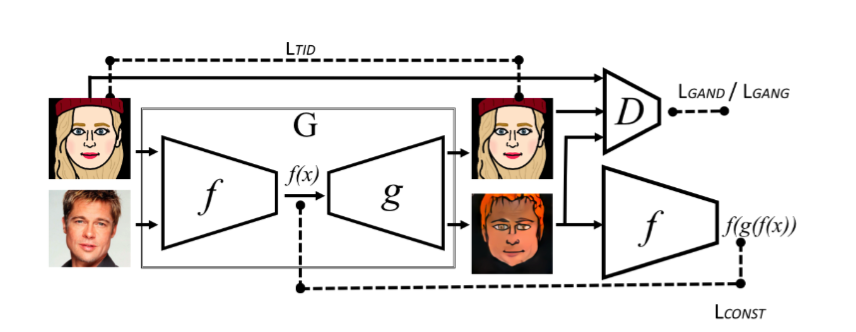

## Formulation

### Discriminator's Loss

$L_{D}= - E_{x\in s}logD_{1}(g(f(x))) - E_{x\in t}logD_{2}(G(f(x))) - E_{x \in t}logD_{3}(x)$

- s and t are pdf
- $D_1 , D_2$ Estimate conversions within the same domain or across domains
- $D_3$ is a traditional discriminator, which evaluates the authenticity of images (are they real or generated)

### Generator's Loss

$L_{G} = L_{GANG} + \alpha L_{CONST} + \beta L_{TID} + \gamma L_{TV}$

$L_{GANG} = - E_{x \in s}logD_{3}(g(f(x))) - E_{x \in t}logD_{3}(g(f(x)))$

$L_{CONST} = \sum_{x \in s} d(f(x),f(g(f(x))))$

$L_{TID}=\sum_{x \in t} d_{2}(x,G(x))$

- $L_G$ Total loss for generator.
- $L_{GANG}$ is the adversarial loss for the generator.
- $L_{CONST}$ represents a consistency loss. It measures the distance between the feature representation of the original input and the output.
- $L_{TID}$ is target identity Loss, it measures the distance between the target sample and its generated version.
- $L_{TV}$ is a regularization loss.
- $d , d_2$ is $L_2$ Normal.

## Implementation

### Download the data

In [75]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import pickle
from tensorflow.keras.layers import Resizing
import os
import numpy as np
import pickle
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt

In [5]:
!cd /Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/data

### Download svhn data

In [6]:
!mkdir -p mnist
!mkdir -p svhn

!wget -O svhn/train_32x32.mat http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget -O svhn/test_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
!wget -O svhn/extra_32x32.mat http://ufldl.stanford.edu/housenumbers/extra_32x32.mat

--2024-06-07 12:20:48--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘svhn/train_32x32.mat’

svhn/train_32x32.ma 100%[===================>] 173.61M  5.44MB/s    in 45s     

2024-06-07 12:21:34 (3.84 MB/s) - ‘svhn/train_32x32.mat’ saved [182040794/182040794]

--2024-06-07 12:21:34--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘svhn/test_32x32.mat’

svhn/test_32x32.mat 100%[===================>]  61.30M  4.56MB/s    in 25s     

2024-06-07 12:22:00 (2.49 MB/s) - ‘svhn/test_32x32.mat

### Download Mnist data and resize

In [7]:
# Specify the path to save the MNIST data
data_dir = '/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/data/mnist'

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Create a Resize layer to resize images from 28x28 to 32x32
resize_layer = Resizing(32, 32, interpolation='bilinear')

# Expand the dimensions of the images to add a channel dimension (grayscale)
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

# Apply the resize operation to training and test images
train_images_resized = resize_layer(train_images)
test_images_resized = resize_layer(test_images)

# Normalize the images to [0, 1]
train_images_resized = train_images_resized / 255.0
test_images_resized = test_images_resized / 255.0

# Save as dictionary structure and serialize to pickle file
train_data = {'X': train_images_resized.numpy(), 'y': train_labels}
test_data = {'X': test_images_resized.numpy(), 'y': test_labels}

with open(f'{data_dir}/mnist_train.pkl', 'wb') as f:
    pickle.dump(train_data, f)
with open(f'{data_dir}/mnist_test.pkl', 'wb') as f:
    pickle.dump(test_data, f)

print('MNIST dataset successfully saved!')

MNIST dataset successfully saved!


### Load data

In [8]:
def load_svhn(image_dir, split='train'):
    print ('loading svhn image dataset..')
        
#     if self.model.mode == 'pretrain':
#         image_file = 'extra_32x32.mat' if split=='train' else 'test_32x32.mat'
#     else:
#         image_file = 'train_32x32.mat' if split=='train' else 'test_32x32.mat'
    image_file = 'train_32x32.mat' if split=='train' else 'test_32x32.mat'        
    image_dir = os.path.join(image_dir, image_file)
    svhn = scipy.io.loadmat(image_dir)
    images = np.transpose(svhn['X'], [3, 0, 1, 2]) / 127.5 - 1
    labels = svhn['y'].reshape(-1)
    labels[np.where(labels==10)] = 0
    print ('finished loading svhn image dataset..!')
    return images, labels

In [9]:
def load_mnist(image_dir, split='train'):
    print ('loading mnist image dataset..')
    image_file = 'mnist_train.pkl' if split=='train' else 'mnist_test.pkl'
    image_dir = os.path.join(image_dir, image_file)
    with open(image_dir, 'rb') as f:
        mnist = pickle.load(f)
    images = mnist['X'] / 127.5 - 1
    labels = mnist['y']
    print ('finished loading mnist image dataset..!')
    return images, labels

In [10]:
def merge_images(sources, targets, k=10):
    _, h, w, _ = sources.shape
    row = int(np.sqrt(self.batch_size))
    merged = np.zeros([row*h, row*w*2, 3])

    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[i*h:(i+1)*h, (j*2)*h:(j*2+1)*h, :] = s
        merged[i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h, :] = t
    return merged

In [11]:
svhn_dir = "/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/data/svhn"
mnist_dir = "/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/data/mnist"

svhn_images, _ = load_svhn(svhn_dir, split='train')
mnist_images, _ = load_mnist(mnist_dir, split='train')

loading svhn image dataset..
finished loading svhn image dataset..!
loading mnist image dataset..
finished loading mnist image dataset..!


In [12]:
svhn_images[1].shape

(32, 32, 3)

In [13]:
mnist_images[1].shape

(32, 32, 1)

### Plotting images

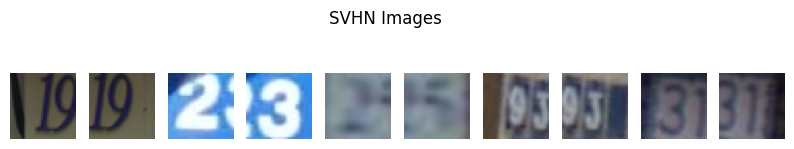

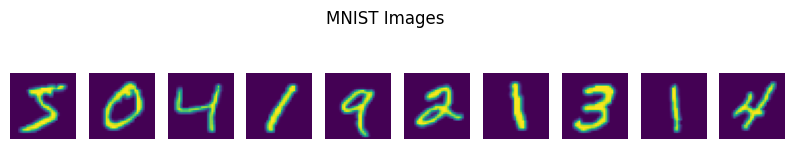

In [14]:
# Plotting SVHN and MNIST images
def plot_images(images, title, num_images=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow((images[i] + 1) / 2)  # Normalize back to [0, 1] for display
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot 10 images from SVHN
plot_images(svhn_images, "SVHN Images", num_images=10)

# Plot 10 images from MNIST
plot_images(mnist_images, "MNIST Images", num_images=10)

### Extractor

In [68]:
# Define the Content Extractor
# input 32*32*3 or 32*32*1
# output 1*1*128

import tensorflow as tf


def content_extractor(images, training=False):
    # Handle grayscale images
    if images.shape[-1] == 1:
        x = tf.image.grayscale_to_rgb(images)
    else:
        x = images

    # Define layers
    x = layers.Conv2D(64, (3, 3), padding='same', strides=2, 
                      kernel_initializer='glorot_uniform')(x)
    x = layers.BatchNormalization(momentum=0.95)(x, training=training)
    x = tf.nn.relu(x)

    x = layers.Conv2D(128, (3, 3), padding='same', strides=2, 
                      kernel_initializer='glorot_uniform')(x)
    x = layers.BatchNormalization(momentum=0.95)(x, training=training)
    x = tf.nn.relu(x)

    x = layers.Conv2D(256, (3, 3), padding='same', strides=2, 
                      kernel_initializer='glorot_uniform')(x)
    x = layers.BatchNormalization(momentum=0.95)(x, training=training)
    x = tf.nn.relu(x)

    x = layers.Conv2D(128, (4, 4), padding='valid', 
                      kernel_initializer='glorot_uniform')(x)
    x = layers.BatchNormalization(momentum=0.95)(x, training=training)
    x = tf.nn.tanh(x)

    return x




#### Padding = 'same'
- **'same' padding** means that the input tensor is padded in such a way that the output tensor has the same height and width as the input tensor.
- Padding is added equally to both sides of the input. If the kernel size is even, extra padding may be added to the bottom and right sides.
- This is useful when you want the output to have the same spatial dimensions as the input.

#### Padding = 'valid'
- **'valid' padding** means no padding is added to the input tensor. The convolution is only applied to valid positions where the entire filter fits inside the input dimensions.
- This results in an output tensor that is smaller than the input tensor, depending on the filter size and stride.
- This is useful when you want to reduce the spatial dimensions of the output.

#### Calculation of Output Shape

##### Same Padding:
For a given input dimension \(I\), kernel size \(K\), stride \(S\), and padding \(P\), the output dimension \(O\) is calculated as:
$ O = \left\lceil \frac{I}{S} \right\rceil $

##### Valid Padding:
For the same parameters, the output dimension \(O\) is calculated as:
$ O = \left\lfloor \frac{I - K + 1}{S} \right\rfloor $

#### Example Calculations:

##### Same Padding:
For an input of 32x32, kernel size of 3x3, and stride of 1:
$ O = \left\lceil \frac{32}{1} \right\rceil = 32 $

##### Valid Padding:
For an input of 32x32, kernel size of 3x3, and stride of 1:
$ O = \left\lfloor \frac{32 - 3 + 1}{1} \right\rfloor = 30 $


### Generator

In [69]:
# Define the Generator
# input 1*1*128
# output 32*32*1

def generator(images, training=False):
    # First Conv2DTranspose layer: 4x4 filters, stride 1, padding 'valid'
    x = tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=1, padding='valid', use_bias=False)(images)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    # Second Conv2DTranspose layer: 3x3 filters, stride 2, padding 'same'
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    # Third Conv2DTranspose layer: 3x3 filters, stride 2, padding 'same'
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)

    # Fourth Conv2DTranspose layer: 3x3 filters, stride 2, padding 'same'
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    # Fifth Conv2DTranspose layer: 3x3 filters, stride 1, padding 'same', output shape [batch_size, 32, 32, 1]
    x = tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=1, padding='same', activation=tf.nn.tanh, use_bias=False)(x)
    
    return x



### Discriminator

In [70]:
# Define the Discriminator
# input 32*32*3 or 32*32*1
# output 1

def discriminator(images, training=False):
    # First Conv2D layer: 3x3 filters, stride 2, padding 'same'
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=2, padding='same', activation=tf.nn.relu, use_bias=False)(images)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    
    # Second Conv2D layer: 3x3 filters, stride 2, padding 'same'
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=2, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    # Third Conv2D layer: 3x3 filters, stride 1, padding 'same'
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.ReLU()(x)
    
    # Fourth Conv2D layer: 4x4 filters, stride 1, padding 'valid'
    x = tf.keras.layers.Conv2D(1, (4, 4), strides=1, padding='valid', activation=None, use_bias=False)(x)
    x = tf.keras.layers.Flatten()(x)
    
    # Dense layer to produce the final output
    # Not use active function sigmoid to make the output from [0, 1]
    # It will do in the caculate of loss by logits
    x = tf.keras.layers.Dense(1)(x)
    
    return x


In [71]:
src_images = tf.keras.Input(shape=(32, 32, 3))
trg_images = tf.keras.Input(shape=(32, 32, 1))

In [72]:
# source domain (svhn to mnist)
fx = content_extractor(src_images)
fake_images = generator(fx)
logits = discriminator(fake_images)
fgfx = content_extractor(fake_images)

### Source domain loss

In [80]:
# Discriminator loss for source domain (real vs fake)
d_loss_src = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
    y_true=tf.zeros_like(logits), 
    y_pred=logits
)

# Generator loss for source domain (fake images should be classified as real)
g_loss_src = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
    y_true=tf.ones_like(logits), 
    y_pred=logits
)

# Feature matching loss (Mean Squared Error)
f_loss_src = tf.reduce_mean(tf.square(fx - fgfx)) * 15.0


In [88]:
learning_rate=0.0003

# Define optimizers
d_optimizer_src = tf.keras.optimizers.Adam(learning_rate=learning_rate)
g_optimizer_src = tf.keras.optimizers.Adam(learning_rate=learning_rate)
f_optimizer_src = tf.keras.optimizers.Adam(learning_rate=learning_rate)

### Target domain loss

In [89]:
# target domain (mnist)
fx = content_extractor(trg_images)
reconst_images = generator(fx)
logits_fake = discriminator(reconst_images)
logits_real = discriminator(trg_images)

In [90]:
# Discriminator loss for fake target images
d_loss_fake_trg = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake)
# Discriminator loss for real target images
d_loss_real_trg = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real)
# Total discriminator loss
d_loss_trg = tf.reduce_mean(d_loss_fake_trg) + tf.reduce_mean(d_loss_real_trg)

# Generator loss for fake target images (should be classified as real)
g_loss_fake_trg = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits=logits_fake)
# Generator constant loss (e.g., L2 loss between target and reconstructed images)
g_loss_const_trg = tf.reduce_mean(tf.square(trg_images - reconst_images)) * 15.0
# Total generator loss
g_loss_trg = tf.reduce_mean(g_loss_fake_trg) + g_loss_const_trg


In [92]:
learning_rate=0.0003
d_optimizer_trg = tf.keras.optimizers.Adam(learning_rate=learning_rate)
g_optimizer_trg = tf.keras.optimizers.Adam(learning_rate=learning_rate)